In [6]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image
import scipy

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import Callback
from keras.losses import mean_squared_error
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/SRx4.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
                                                    'charbonnierLoss': charbonnierLoss})

<class 'keras.engine.training.Model'>


(1, 16, 16, 3)
(64, 64, 3)
[0.05882353 0.11372549 0.05882353]
[-0.03838708  0.07133056 -0.0624404 ]


c:\users\rechant\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


<IPython.core.display.Javascript object>


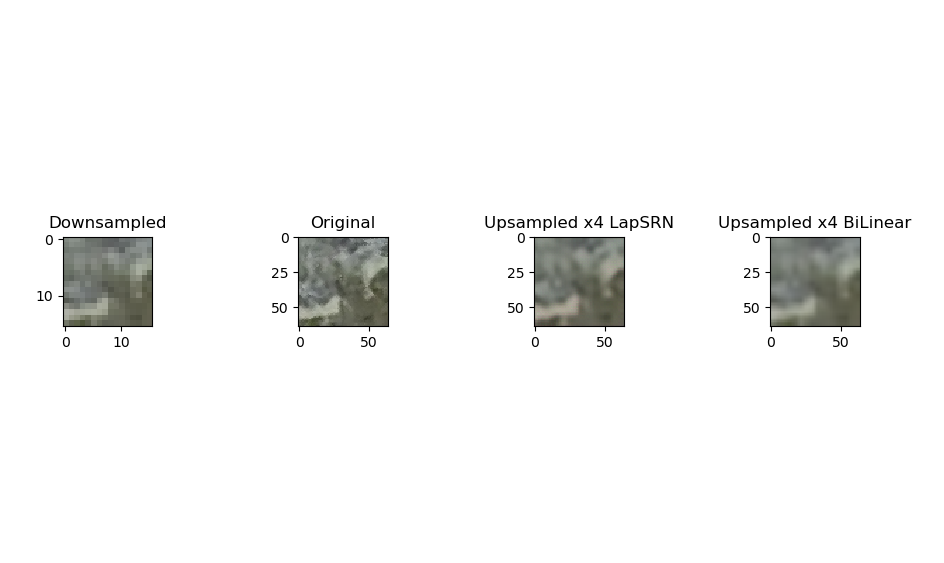

519.19287109375 20.97751640222558
771.383056640625 19.258102654723107


In [28]:
imgpath = '../Images/Training_Patchesx4/Branching/Branching_00000026.png'
truthpath = '../Images/TrainingRefx4_Patches/Branching/Branching_00000026.png'

img = load_img(imgpath, grayscale=0, target_size=(16,16))
imgresize = scipy.misc.imresize(img,400,'bilinear')
img = img_to_array(img, data_format=K.image_data_format())
img = (img-127.5)/127.5
imgbatch = np.expand_dims(img, axis=0)
print(imgbatch.shape)
imgpredict = model.predict(imgbatch, batch_size = 1)[0]


print(imgpredict.shape)
imgtruth = load_img(truthpath, grayscale=0, target_size=(64,64))
imgtruth = img_to_array(imgtruth, data_format=K.image_data_format())
imgtruth = (imgtruth-127.5)/127.5
print(imgtruth[0,0,:])
print(imgpredict[0,0,:])

# a = charbonnierLoss(imgtruth,imgpredict)
# init_op = tf.initialize_all_variables()
# with tf.Session() as sess:
#     sess.run(init_op)
#     print(sess.run(a))


fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(np.asarray(img*127.5+127.5,dtype=np.uint8))
ax1.set_title('Downsampled')

ax3 = fig.add_subplot(1,4,2)
ax3.imshow(np.asarray(imgtruth*127.5+127.5,dtype=np.uint8))
ax3.set_title('Original')

ax2 = fig.add_subplot(1,4,3)
ax2.imshow(np.asarray(imgpredict*127.5+127.5,dtype=np.uint8))
ax2.set_title('Upsampled x4 LapSRN')

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.asarray(imgresize,dtype=np.uint8))
ax4.set_title('Upsampled x4 BiLinear')

fig.tight_layout()
plt.show()

MSE1 = np.sum(np.square((imgpredict*127.5+127.5) - (imgtruth*127.5+127.5)))/(64*64)
MSE2 = np.sum(np.square((imgtruth*127.5+127.5) - (imgresize)))/(64*64)
PSNR1 = 10*np.log10(255*255/MSE1)
PSNR2 = 10*np.log10(255*255/MSE2)
    
print(MSE1, PSNR1)
print(MSE2, PSNR2)

